In [1]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
import lsqfit
import itertools
from tqdm import tqdm

In [2]:
from b2heavy.FnalHISQMetadata import params as mData

In [3]:
from b2heavy.ThreePointFunctions.utils     import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.globalfit import RatioSet

In [4]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'

In [5]:
ENSEMBLE = 'Fine-1'

In [6]:
MOMLIST = ['000','100','200','300']
RATLIST = ['QPLUS','RPLUS','RMINUS','XF']

SMSLIST = ['1S','RW']

cov_specs = dict(scale=True,shrink=True,cutsvd=1E-12)

In [7]:
rset = RatioSet(ENSEMBLE,MOMLIST,RATLIST,SMSLIST)
rset.collect(DATA_DIR,DATA_2PT)

100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


In [8]:
# rset.remove(
#     ('100','QPLUS','RW'),
#     ('200','QPLUS','RW'),
#     ('300','QPLUS','RW'),
# )

In [9]:
tag = f'fit2pt_config_{ENSEMBLE}_D_000'
fit,pars = read_config_fit(tag,path=DATA_2PT)
dE_D = np.exp(pars['dE'][1])

tag = f'fit2pt_config_{ENSEMBLE}_B_000'
fit,pars = read_config_fit(tag,path=DATA_2PT)
dM_B = np.exp(pars['dE'][1])

In [10]:
priors = rset.params(
    dE_D = dE_D,
    dM_D = dE_D,
    dM_B = dM_B,
)

In [11]:
TMIN = 2

fit = rset.fit(
    tmin   = TMIN,
    priors = priors,
    **cov_specs
)   

rset.show(fit)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


f0                        A_1S  \
mom ratio                                             
000 RPLUS    1.0411(56)  [-0.0280(58), -0.0352(61)]   
100 QPLUS    0.9817(22)   [-0.0093(37), 0.0028(21)]   
    RMINUS  -0.0884(14)    [0.0284(52), 0.0020(24)]   
    XF      -0.0770(11)    [0.0353(29), 0.0003(25)]   
200 QPLUS    0.9492(40)   [-0.0577(79), 0.0143(52)]   
    RMINUS  -0.1761(16)    [0.0665(73), 0.0115(37)]   
    XF      -0.1542(14)    [0.0776(37), 0.0050(39)]   
300 QPLUS    0.9128(79)     [-0.143(12), 0.034(14)]   
    RMINUS  -0.2535(30)     [0.091(10), 0.0246(87)]   
    XF      -0.2249(22)    [0.1151(50), 0.0204(86)]   

                                  A_RW                        B_1S  \
mom ratio                                                            
000 RPLUS   [-0.0297(59), -0.0283(73)]  [-0.0280(58), -0.0352(61)]   
100 QPLUS     [0.0124(28), 0.0002(19)]   [-0.0093(37), 0.0028(21)]   
    RMINUS   [-0.0119(59), 0.0017(22)]    [0.0284(52), 0.0020(24)]   
    XF      [-0.0264(29), -0.0002(22)]    [0.0353(29), 0.0003(25)]   
200 QPLUS     [0.0242(57), 0.0094(42)]   [-0.0577(79), 0.0143(52)]   
    RMINUS   [-0.0104(69), 0.0124(32)]    [0.0665(73), 0.0115(37)]   
    XF       [-0.0421(32), 0.0071(30)]    [0.0776(37), 0.0050(39)]   
300 QPLUS     [0.0405(88), 0.0222(88)]     [-0.143(12), 0.034(14)]   
    RMINUS   [-0.0080(80), 0.0225(62)]     [0.091(10), 0.0246(87)]   
    XF       [-0.0576(40), 0.0114(60)]    [0.1151(50), 0.0204(86)]   

                                  B_RW  
mom ratio                               
000 RPLUS   [-0.0297(59), -0.0283(73)]  
100 QPLUS     [0.0124(28), 0.0002(19)]  
    RMINUS   [-0.0119(59), 0.0017(22)]  
    XF      [-0.0264(29), -0.0002(22)]  
200 QPLUS     [0.0242(57), 0.0094(42)]  
    RMINUS   [-0.0104(69), 0.0124(32)]  
    XF       [-0.0421(32), 0.0071(30)]  
300 QPLUS     [0.0405(88), 0.0222(88)]  
    RMINUS   [-0.0080(80), 0.0225(62)]  
    XF       [-0.0576(40), 0.0114(60)]

In [79]:
rset.fit_result(TMIN,fit,priors=priors)

# ---------- Global fit in 2 for ens: Fine-1 --------------
Least Square Fit:
  chi2/dof [dof] = 0.84 [280]    Q = 0.98    logGBF = 1314

Parameters:
           dE_D    0.3143 (86)      [   0.357 (25) ]  *
           dM_B     0.288 (38)      [   0.314 (45) ]  
           dM_D    0.3143 (86)      [   0.357 (25) ]  *
   RPLUS_000_f0    1.0411 (56)      [    1.0 (1.5) ]  
 RPLUS_000_1S 0   -0.0280 (58)      [      0 ± 1.0 ]  
              1   -0.0352 (61)      [      0 ± 1.0 ]  
 RPLUS_000_RW 0   -0.0297 (59)      [      0 ± 1.0 ]  
              1   -0.0283 (73)      [      0 ± 1.0 ]  
   QPLUS_100_f0    0.9817 (22)      [    1.0 (1.5) ]  
 QPLUS_100_1S 0   -0.0093 (37)      [      0 ± 1.0 ]  
              1    0.0028 (21)      [      0 ± 1.0 ]  
 QPLUS_100_RW 0    0.0124 (28)      [      0 ± 1.0 ]  
              1    0.0002 (19)      [      0 ± 1.0 ]  
  RMINUS_100_f0   -0.0884 (14)      [ -0.09 (1.50) ]  
RMINUS_100_1S 0    0.0284 (52)      [      0 ± 1.0 ]  
              1    0.00

{'fit': <lsqfit.nonlinear_fit at 0x174d13590>,
 'chi2red': 231.12013561006682,
 'chi2aug': 237.16605178746306,
 'chiexp': 279.9999999999972,
 'pexp': 0.971,
 'pstd': 0.9835613055078025}

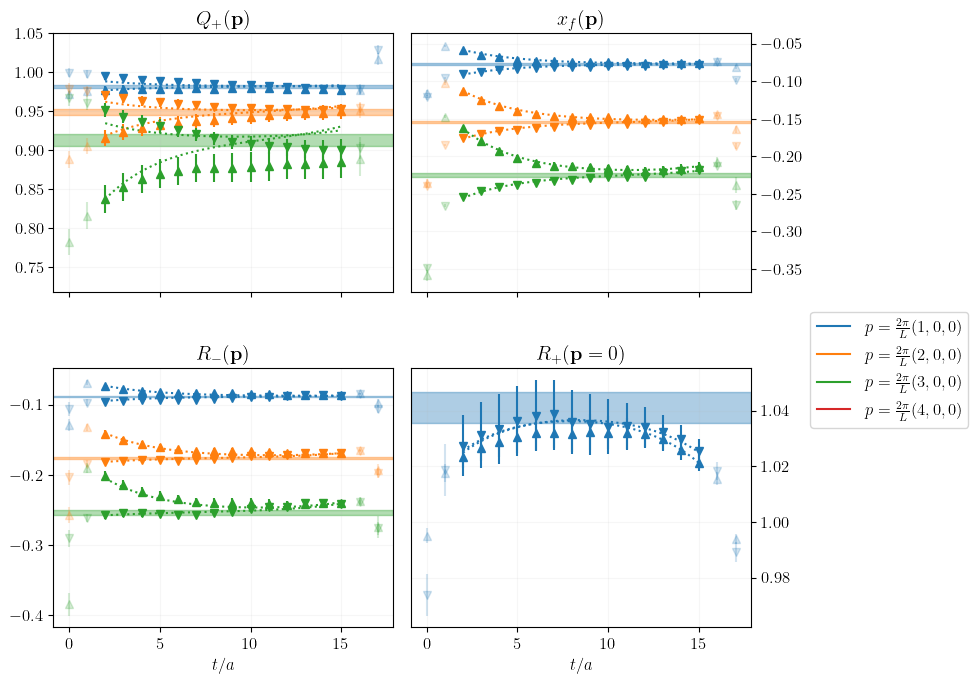

In [80]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

f, ax = plt.subplots(2,2,figsize=(10,7), sharex=True)

rset.plot_fit('QPLUS' ,fit,ax[0,0])
ax[0,0].set_title(r'$Q_{+}(\mathbf{p})$')
# ax[0,0].set_ylim(0.8,1.05)
ax[0,0].set_ylim(ymax=1.05)
ax[0,0].grid(alpha=0.1)

rset.plot_fit('XF'    ,fit,ax[0,1])
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_title(r'$x_f(\mathbf{p})$')
# ax[0,1].set_ylim(ymin=-0.3)
ax[0,1].grid(alpha=0.1)


rset.plot_fit('RMINUS',fit,ax[1,0])
ax[1,0].grid(alpha=0.1)
# ax[1,0].set_ylim(ymin=-0.3)
ax[1,0].set_title(r'$R_-(\mathbf{p})$')
ax[1,0].set_xlabel(r'$t/a$')

rset.plot_fit('RPLUS' ,fit,ax[1,1])
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
# ax[1,1].set_ylim(ymin=0.9)
ax[1,1].grid(alpha=0.1)
ax[1,1].set_title(r'$R_+(\mathbf{p}=0)$')
ax[1,1].set_xlabel(r'$t/a$')


ax[1,1].errorbar([],[],color='C0',label=r'$p = \frac{2\pi}{L}(1,0,0)$')
ax[1,1].errorbar([],[],color='C1',label=r'$p = \frac{2\pi}{L}(2,0,0)$')
ax[1,1].errorbar([],[],color='C2',label=r'$p = \frac{2\pi}{L}(3,0,0)$')
ax[1,1].errorbar([],[],color='C3',label=r'$p = \frac{2\pi}{L}(4,0,0)$')
ax[1,1].legend(bbox_to_anchor=(1.15, 1.25))



# plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplots_adjust(wspace=0.05)

plt.tight_layout()

# plt.savefig(
#     f'/Users/pietro/code/latex/Lattice2024/beamer-presentation-template/PLOTS/ratio_gfit_D.pdf',
#     transparent=True
# )




# Stability test

In [102]:
tmins = [1,2,3,4]

aux = []
TIC = []
pfs = []
for tmin in tqdm(tmins):
    fit = rset.fit(tmin=tmin, priors=priors,**cov_specs)   
    aux.append(
        {k: p for k,p in fit.p.items() if k.endswith('f0')}
    )
    
    res = rset.fit_result(tmin,fit,priors=priors,verbose=False)
    TIC.append(res['chi2aug'] - 2*res['chiexp'])
    pfs.append(res['pstd'])

100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


In [103]:
w = np.exp(-np.array(TIC)/2)
w /= sum(w)
for i,weight in enumerate(w):
    print(f'{tmins[i] = },    {weight = },    {pfs[i] = }')

tmins[i] = 1,    weight = 0.9999995109485724,    pfs[i] = 0.6892831804385479
tmins[i] = 2,    weight = 4.890513665820046e-07,    pfs[i] = 0.6699382512796499
tmins[i] = 3,    weight = 6.109216310405352e-14,    pfs[i] = 0.7046525825989521
tmins[i] = 4,    weight = 9.95102280250038e-21,    pfs[i] = 0.8576166454208465


In [104]:
df = pd.DataFrame(aux)
df

,RPLUS_000_f0,QPLUS_100_f0,RMINUS_100_f0,XF_100_f0,QPLUS_200_f0,RMINUS_200_f0,XF_200_f0,QPLUS_300_f0,RMINUS_300_f0,XF_300_f0
0,1.0174(49),0.9766(29),-0.1346(20),-0.1165(12),0.9150(98),-0.2469(37),-0.2200(22),0.848(21),-0.3299(90),-0.3011(44)
1,1.060(53),0.984(18),-0.142(17),-0.1175(15),0.971(85),-0.263(29),-0.2229(26),1.03(25),-0.345(50),-0.3063(56)
2,1.083(93),1.010(53),-0.183(74),-0.1193(18),1.02(18),-0.34(13),-0.2245(30),1.15(46),-0.47(21),-0.3112(72)
3,1.0187(82),0.9720(61),-0.1340(61),-0.1197(37),0.898(16),-0.248(12),-0.2251(71),0.822(45),-0.354(26),-0.319(16)


/var/folders/7m/b37v945d74n14brv9wkfxwpw0000gn/T/ipykernel_52471/4150968021.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


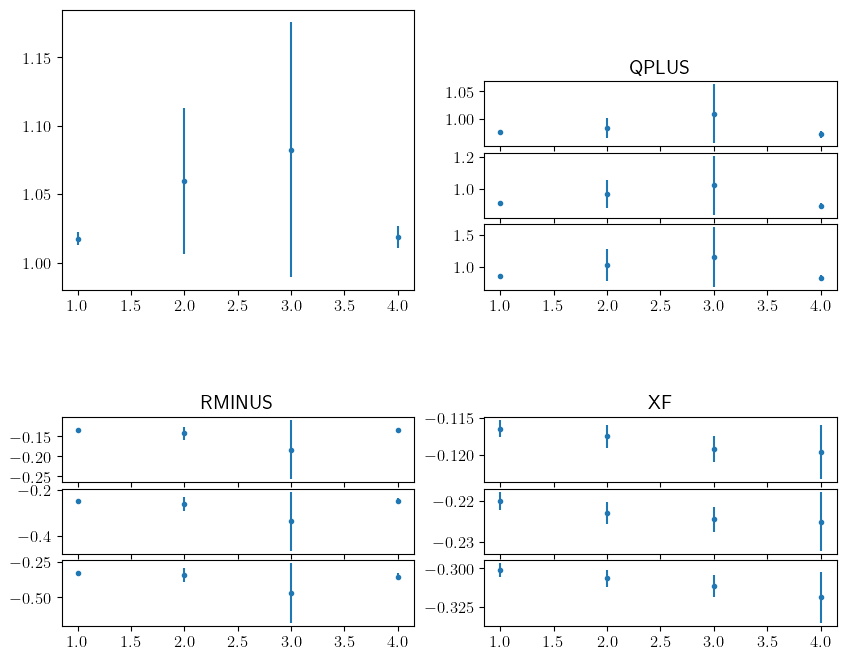

In [105]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)


inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0], wspace=0.1, hspace=0.1)
ax = plt.Subplot(fig,inner[0])
rs = df['RPLUS_000_f0'].values
ax.errorbar(tmins, gv.mean(rs), gv.sdev(rs), fmt='.')
fig.add_subplot(ax)




inner1 = gridspec.GridSpecFromSubplotSpec(len(MOMLIST), 1, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
inner2 = gridspec.GridSpecFromSubplotSpec(len(MOMLIST), 1, subplot_spec=outer[2], wspace=0.1, hspace=0.1)
inner3 = gridspec.GridSpecFromSubplotSpec(len(MOMLIST), 1, subplot_spec=outer[3], wspace=0.1, hspace=0.1)

for j,mom in enumerate(MOMLIST):
    if mom=='000':
        continue

    ax = plt.Subplot(fig,inner1[j])
    rs = df[f'QPLUS_{mom}_f0'].values
    ax.errorbar(tmins, gv.mean(rs), gv.sdev(rs), fmt='.')
    if mom=='100':
        ax.set_title('QPLUS')
    fig.add_subplot(ax)

    ax = plt.Subplot(fig,inner2[j])
    rs = df[f'RMINUS_{mom}_f0'].values
    ax.errorbar(tmins, gv.mean(rs), gv.sdev(rs), fmt='.')
    if mom=='100':
        ax.set_title('RMINUS')
    fig.add_subplot(ax)

    ax = plt.Subplot(fig,inner3[j])
    rs = df[f'XF_{mom}_f0'].values
    ax.errorbar(tmins, gv.mean(rs), gv.sdev(rs), fmt='.')
    if mom=='100':
        ax.set_title('XF')
    fig.add_subplot(ax)


fig.show()

In [106]:
df

,RPLUS_000_f0,QPLUS_100_f0,RMINUS_100_f0,XF_100_f0,QPLUS_200_f0,RMINUS_200_f0,XF_200_f0,QPLUS_300_f0,RMINUS_300_f0,XF_300_f0
0,1.0174(49),0.9766(29),-0.1346(20),-0.1165(12),0.9150(98),-0.2469(37),-0.2200(22),0.848(21),-0.3299(90),-0.3011(44)
1,1.060(53),0.984(18),-0.142(17),-0.1175(15),0.971(85),-0.263(29),-0.2229(26),1.03(25),-0.345(50),-0.3063(56)
2,1.083(93),1.010(53),-0.183(74),-0.1193(18),1.02(18),-0.34(13),-0.2245(30),1.15(46),-0.47(21),-0.3112(72)
3,1.0187(82),0.9720(61),-0.1340(61),-0.1197(37),0.898(16),-0.248(12),-0.2251(71),0.822(45),-0.354(26),-0.319(16)


# Fix tmin

In [81]:
ens = 'Coarse-2'
a = mData(ens)['aSpc'].mean
T = 2
t = a*T

for ens in ['MediumCoarse','Coarse-2','Coarse-Phys','Coarse-1','Fine-1','Fine-Phys','SuperFine']:
    a = mData(ens)['aSpc'].mean

    print(ens,t/a,round(t/a))

MediumCoarse 1.6578243585110228 2
Coarse-2 2.0 2
Coarse-Phys 2.0481387784604266 2
Coarse-1 2.030646910010842 2
Fine-1 2.789880737260571 3
Fine-Phys 2.8146006505240337 3
SuperFine 4.354029634983736 4
